In [1]:
import pandas as pd
import os # We'll use this briefly to confirm the working directory

# Confirmation (Optional, but good practice):
print(f"Current Working Directory: {os.getcwd()}") 
print("-" * 30)

# 1. Define the File Path
file_name = 'CONVENIENT_global_confirmed_cases.csv'
# The path works because you launched Jupyter from the root, 
# and the data folder is directly inside the root.
file_path = 'data/' + file_name 

# 2. Load the Data
try:
    df_confirmed = pd.read_csv(file_path) 
    
    # 3. Initial Inspection
    print("✅ Data successfully loaded!")
    print("\n--- First 5 Rows (Head) ---")
    print(df_confirmed.head()) 
    print("\n--- Data Information (Columns and Types) ---")
    df_confirmed.info() # Use the function directly here
    
except FileNotFoundError:
    print(f"❌ Error: Something is still wrong with the path: {file_path}")
    print("Please double-check the file name or folder.")

Current Working Directory: C:\Users\user\covid-data-dashboard
------------------------------
✅ Data successfully loaded!

--- First 5 Rows (Head) ---
   Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  Antarctica  \
0  Province/State          NaN      NaN      NaN      NaN     NaN         NaN   
1         1/23/20          0.0      0.0      0.0      0.0     0.0         0.0   
2         1/24/20          0.0      0.0      0.0      0.0     0.0         0.0   
3         1/25/20          0.0      0.0      0.0      0.0     0.0         0.0   
4         1/26/20          0.0      0.0      0.0      0.0     0.0         0.0   

   Antigua and Barbuda  Argentina  Armenia  ... Uruguay Uzbekistan Vanuatu  \
0                  NaN        NaN      NaN  ...     NaN        NaN     NaN   
1                  0.0        0.0      0.0  ...     0.0        0.0     0.0   
2                  0.0        0.0      0.0  ...     0.0        0.0     0.0   
3                  0.0        0.0      0.0  ...    

In [5]:
# The loaded DataFrame is df_confirmed (from the previous step)

# ----------------------------------------------------------------------
# 1. Rename the Date Column
# ----------------------------------------------------------------------
df_confirmed = df_confirmed.rename(columns={'Country/Region': 'Date'})

# ----------------------------------------------------------------------
# 2. Melt the Data (Convert from Wide to Long Format)
# ----------------------------------------------------------------------
df_long = df_confirmed.melt(
    id_vars=['Date'],        
    var_name='Country/Region', 
    value_name='Confirmed_Cases' 
)

# ----------------------------------------------------------------------
# 3. Clean and Inspect the Final Data (CRITICAL FIXES HERE)
# ----------------------------------------------------------------------
# FIX 1: Convert Dates (using coerce and dropping NaT for the "Province/State" artifact)
df_long['Date'] = pd.to_datetime(
    df_long['Date'], 
    format='%m/%d/%y', 
    errors='coerce'
)
df_long.dropna(subset=['Date'], inplace=True)

# FIX 2: Convert Confirmed_Cases to numeric, coercing any non-numeric strings to NaN
# This solves the TypeError: '>' not supported between instances of 'str' and 'int'
df_long['Confirmed_Cases'] = pd.to_numeric(
    df_long['Confirmed_Cases'], 
    errors='coerce'
)

# Remove any rows where cases were non-numeric (now NaN)
df_long.dropna(subset=['Confirmed_Cases'], inplace=True)

# Drop rows where the confirmed cases are zero 
df_long = df_long[df_long['Confirmed_Cases'] > 0] 

# Cast the Confirmed_Cases column to the final integer type
df_long['Confirmed_Cases'] = df_long['Confirmed_Cases'].astype(int)


print("✅ Data cleaning complete. The DataFrame is ready for analysis!")
print("\n--- Final Cleaned Data Head ---")
print(df_long.head())
print("\n--- Final Data Information ---")
df_long.info()

✅ Data cleaning complete. The DataFrame is ready for analysis!

--- Final Cleaned Data Head ---
         Date Country/Region  Confirmed_Cases
33 2020-02-24    Afghanistan                5
45 2020-03-07    Afghanistan                3
49 2020-03-11    Afghanistan                3
52 2020-03-14    Afghanistan                3
53 2020-03-15    Afghanistan                6

--- Final Data Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 175728 entries, 33 to 330325
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             175728 non-null  datetime64[ns]
 1   Country/Region   175728 non-null  object        
 2   Confirmed_Cases  175728 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.4+ MB


✅ Aggregation and Plotting Complete.

--- Aggregated Data Head ---
            Confirmed_Cases  Daily_New_Cases  Rolling_Avg_Cases
Date                                                           
2020-01-23              100                0                NaN
2020-01-24              287              187                NaN
2020-01-25              493              206                NaN
2020-01-26              683              190                NaN
2020-01-27              809              126                NaN
2020-01-28             2651             1842                NaN
2020-01-29              589            -2062          69.857143
2020-01-30             2068             1479         281.142857
2020-01-31             1691             -377         200.571429
2020-02-01             2111              420         231.142857


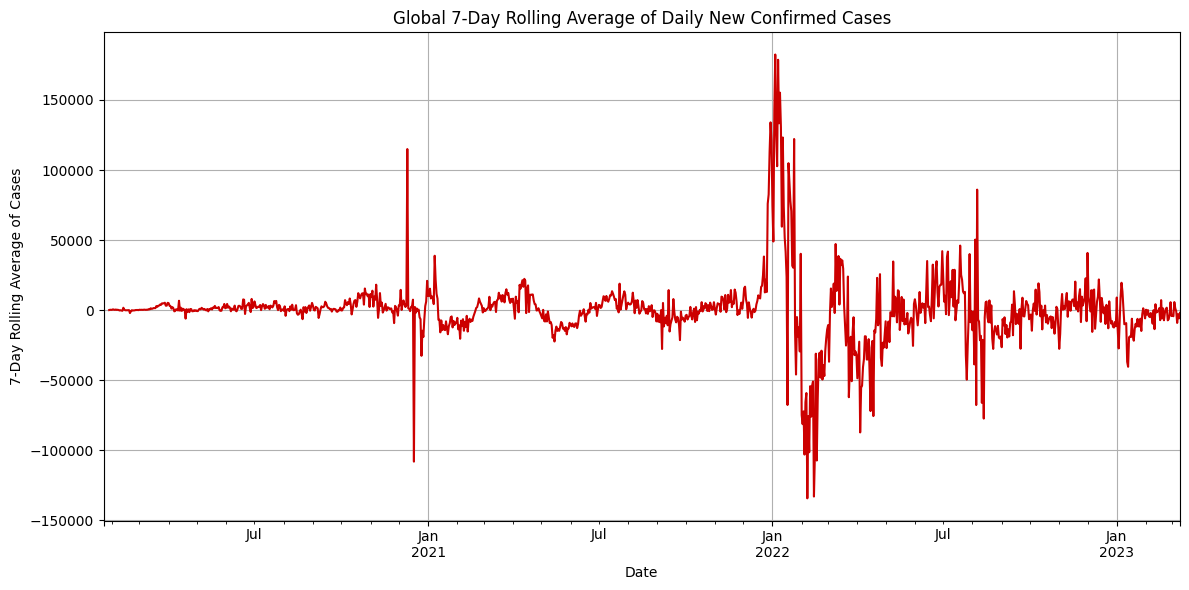

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. Data Aggregation and Analysis
# ----------------------------------------------------------------------

# Aggregate the data to get the total confirmed cases per day globally
# The data is automatically sorted by Date because 'Date' is a datetime object.
df_global = df_long.groupby('Date')['Confirmed_Cases'].sum().reset_index()
df_global.set_index('Date', inplace=True)

# Calculate Daily New Cases
# .diff() finds the difference between the current day and the previous day's total cases.
df_global['Daily_New_Cases'] = df_global['Confirmed_Cases'].diff().fillna(0).astype(int)

# Calculate 7-Day Rolling Average
# This smooths out daily variations (like weekend reporting delays) to show the true trend.
df_global['Rolling_Avg_Cases'] = df_global['Daily_New_Cases'].rolling(window=7).mean()


# ----------------------------------------------------------------------
# 2. Visualization
# ----------------------------------------------------------------------

# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the 7-day rolling average
df_global['Rolling_Avg_Cases'].plot(
    title='Global 7-Day Rolling Average of Daily New Confirmed Cases',
    xlabel='Date',
    ylabel='7-Day Rolling Average of Cases',
    grid=True,
    color='#cc0000' # Red color for visual impact
)

# Ensure layout is tight
plt.tight_layout()

# Save the plot to a file that can be used later in the dashboard
plt.savefig('global_7_day_rolling_avg_cases.png')
# This file is now saved in your project root directory.

print("✅ Aggregation and Plotting Complete.")
print("\n--- Aggregated Data Head ---")
print(df_global.head(10))

Top 10 countries selected for analysis: ['US', 'United Kingdom.14', 'Turkey', 'Korea, South', 'France.11', 'Germany', 'Vietnam', 'India', 'Netherlands.4', 'Spain']


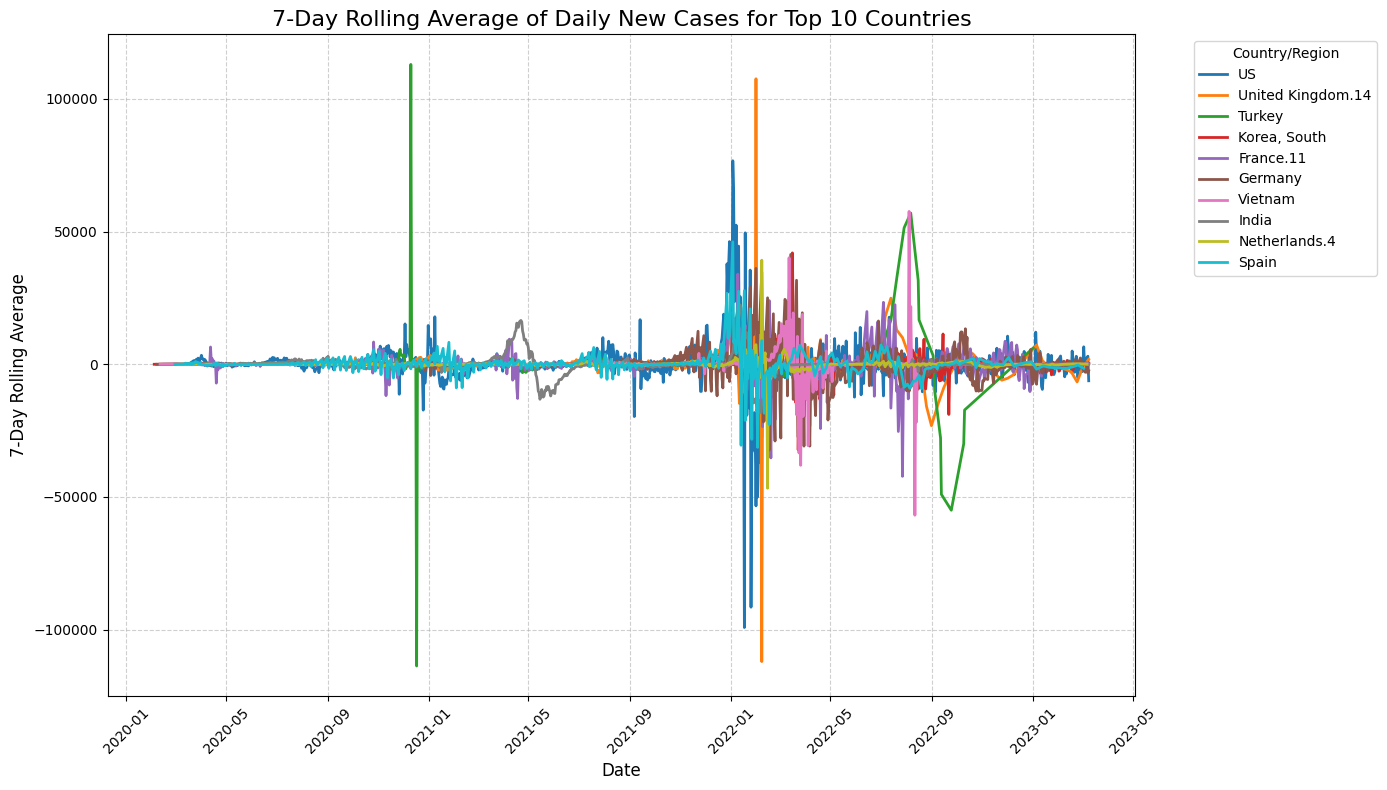

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------------
# 1. Identify Top 10 Countries by Total Cases
# ----------------------------------------------------------------------
# Find the maximum confirmed cases for each country (the final total)
final_totals = df_long.groupby('Country/Region')['Confirmed_Cases'].max()

# Get the names of the top 10 countries
# Note: Some countries appear with suffixes (e.g., 'France.11') due to data structure.
# We will use these exact names for filtering.
top_countries = final_totals.nlargest(10).index.tolist()
print(f"Top 10 countries selected for analysis: {top_countries}")

# ----------------------------------------------------------------------
# 2. Analyze Trends for Top Countries
# ----------------------------------------------------------------------
# Filter the original long DataFrame to only include the top countries
df_top = df_long[df_long['Country/Region'].isin(top_countries)]

# Group by Country AND Date, summing cases to handle any residual data quirks
df_analysis = df_top.groupby(['Country/Region', 'Date'])['Confirmed_Cases'].sum().reset_index()

# Sort the data, which is essential for .diff() and .rolling()
df_analysis = df_analysis.sort_values(by=['Country/Region', 'Date'])

# Calculate Daily New Cases and 7-Day Rolling Average for EACH Country
# We use .groupby().transform() to apply the calculation within each country's data block
df_analysis['Daily_New_Cases'] = df_analysis.groupby('Country/Region')['Confirmed_Cases'].diff().fillna(0).astype(int)
df_analysis['Rolling_Avg_Cases'] = df_analysis.groupby('Country/Region')['Daily_New_Cases'].transform(
    lambda x: x.rolling(window=7).mean()
)

# ----------------------------------------------------------------------
# 3. Visualization for Top Countries
# ----------------------------------------------------------------------
plt.figure(figsize=(14, 8))

# Loop through each of the top countries and plot its rolling average
for country in top_countries:
    subset = df_analysis[df_analysis['Country/Region'] == country]
    # Filter out initial NaN rolling average values
    subset = subset.dropna(subset=['Rolling_Avg_Cases']) 
    plt.plot(subset['Date'], subset['Rolling_Avg_Cases'], label=country, linewidth=2)

plt.title('7-Day Rolling Average of Daily New Cases for Top 10 Countries', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('7-Day Rolling Average', fontsize=12)
# Move the legend outside the plot area for better visibility
plt.legend(title='Country/Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('top_10_country_rolling_avg.png')

In [8]:
# ----------------------------------------------------------------------
# 1. Create Peak Summary Table
# ----------------------------------------------------------------------

# Find the row corresponding to the maximum rolling average for each country
# We group by Country/Region and then use idxmax() to find the index (row) 
# where 'Rolling_Avg_Cases' is highest.
idx_peak = df_analysis.groupby('Country/Region')['Rolling_Avg_Cases'].idxmax()

# Use the indices found to select the corresponding rows from the analysis DataFrame
df_peaks = df_analysis.loc[idx_peak]

# Clean up the final summary table
df_summary = df_peaks[[
    'Country/Region', 
    'Date', 
    'Rolling_Avg_Cases'
]].rename(columns={
    'Date': 'Peak_Wave_1_Date', 
    'Rolling_Avg_Cases': 'Peak_7_Day_Average'
}).sort_values(by='Peak_7_Day_Average', ascending=False).reset_index(drop=True)

# Format the peak cases for readability
df_summary['Peak_7_Day_Average'] = df_summary['Peak_7_Day_Average'].round(0).astype(int)


print("✅ Peak Wave Summary Table Created!")
print("\n--- Top 10 Countries' Peak Case Summary ---")
print(df_summary)

# Save the summary table to a CSV file for the dashboard (final product)
df_summary.to_csv('top_10_country_peak_cases_summary.csv', index=False)

✅ Peak Wave Summary Table Created!

--- Top 10 Countries' Peak Case Summary ---
      Country/Region Peak_Wave_1_Date  Peak_7_Day_Average
0             Turkey       2020-12-10              112978
1  United Kingdom.14       2022-01-31              107568
2                 US       2022-01-03               76674
3            Vietnam       2022-08-04               57592
4              Spain       2022-01-03               46135
5       Korea, South       2022-03-16               41969
6            Germany       2022-03-14               41381
7      Netherlands.4       2022-02-07               39228
8          France.11       2022-01-09               33952
9              India       2022-01-12               22356


In [9]:
# Save the master cleaned DataFrame (df_long) to a CSV file.
# This file will be the primary data source imported into Power BI.
df_long.to_csv('final_covid_long_data.csv', index=False)

print("✅ Master DataFrame successfully exported to final_covid_long_data.csv")

✅ Master DataFrame successfully exported to final_covid_long_data.csv
